In [1]:
# here is how we activate an environment in our current directory
import Pkg; Pkg.activate(@__DIR__);

# instantate this environment (download packages if you haven't)
Pkg.instantiate();

import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
import MeshCat as mc 

  Activating project at `~/Downloads/MSR Academics/zoe2_optimal_controller/julia`


In [2]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))

fmincon (generic function with 1 method)

In [3]:
function dynamics(params::NamedTuple, x::Vector, u::Vector)
    x_pos, y_pos, ϕ = x[1:3]  # States
    ω_fl, ω_fr, ω_rl, ω_rr = u[1:4]  # Inputs
    r, L, B = params.r, params.L, params.B

    ϵ = 1e-6
    # R = (L/4)*((1/(tan(f_steerθ)+ϵ))+(1/(tan(r_steerθ)+ϵ)))
    V_l = (r/2)*(ω_fl+ω_rl)
    V_r = (r/2)*(ω_fr+ω_rr)
    R = (L/2)*(V_l+V_r)/(V_r-V_l+ϵ)
    f_steerθ = atan(L/(2*R+ϵ))
    r_steerθ = atan(L/(2*R+ϵ))

    ## Full Computation
    v = (r/4)*((ω_fl/cos(f_steerθ))+ (ω_fr/cos(f_steerθ))+ (ω_rl/cos(r_steerθ)) + (ω_rr/cos(r_steerθ)))

    ## Small Angle Approximation
    # v = (r/8)*(2+(L/(2*R+ϵ))^2)*(ω_fl+ω_fr+ω_rl+ω_rr)

    xdot = [v*cos(ϕ); v*sin(ϕ); v/(R+ϵ)]
    
    return xdot
end

function rk4(params::NamedTuple, x::Vector,u,dt::Float64)
    # vanilla RK4
    k1 = dt*dynamics(params, x, u)
    k2 = dt*dynamics(params, x + k1/2, u)
    k3 = dt*dynamics(params, x + k2/2, u)
    k4 = dt*dynamics(params, x + k3, u)

    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

rk4 (generic function with 1 method)

In [ ]:
function dynamics_bicycle(params::NamedTuple, x::Vector, u::Vector)
    x_pos, y_pos, ψ, θf, θr = x[1:5]  # States
    ω_fl, ω_fr, ω_rl, ω_rr = u[1:4]  # Inputs
    r, L, B = params.r, params.L, params.B
    ϵ = 1e-6

    v_f = r*(ω_fl+ω_fr)/2
    v_r = r*(ω_rl+ω_rr)/2
    v_b = (1/2)*((v_f/cos(θr))+(v_r/cos(θf)))*√(cos(θf)*cos(θr)*cos(θf+θr)+(1/4)*sin(θf+θr)^2)

    ẋ = v_b*cos(ψ)
    ẏ = v_b*sin(ψ)
    ψ̇ = (sin(θf+θr)/(2*L))*((v_f/cos(θr))+(v_r/cos(θf)))
    θḟ = r*(ω_fr-ω_fl)/B
    θṙ = r*(ω_rl-ω_rr)/B

    xdot = [ẋ; ẏ; ψ̇; θḟ; θṙ]
    # @show v_b, θr, θf
    # @show xdot
    return xdot;
end

In [ ]:
function dynamics_bicycle_nosteer(params::NamedTuple, x::Vector, u::Vector)
    x_pos, y_pos, ψ = x[1:3]  # States
    ω_fl, ω_fr, ω_rl, ω_rr = u[1:4]  # Inputs
    r, L, B = params.r, params.L, params.B
    ϵ = 1e-6

    v_f = r*(ω_fl+ω_fr)/2
    v_r = r*(ω_rl+ω_rr)/2

    V_l = (r/2)*(ω_fl+ω_rl)
    V_r = (r/2)*(ω_fr+ω_rr)
    R = (L/2)*(V_l+V_r)/(V_r-V_l+ϵ)
    θf = atan(L/(2*R+ϵ))
    θr = atan(L/(2*R+ϵ))
    @show θf
    
    v_b = (1/2)*(((v_f/cos(θr))+(v_r/cos(θf)))*√(cos(θf)*cos(θr)*cos(θf+θr)+(1/4)*sin(θf+θr)^2))
    
    ẋ = v_b*cos(ψ)
    ẏ = v_b*sin(ψ)
    ψ̇ = (sin(θf+θr)/(2*L))*((v_f/cos(θr))+(v_r/cos(θf)))

    xdot = [ẋ; ẏ; ψ̇]
    # @show xdot
    return xdot;
end

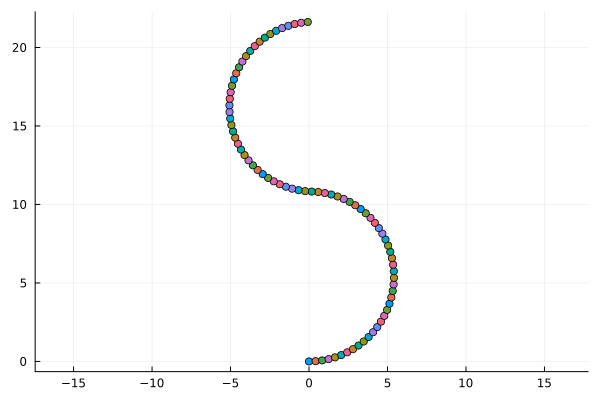

In [4]:
params = (r = 0.325, L = 1.91, B = 1.64)
u = [1.05, 1.5, 1.05, 1.5]

x0 = [0,0,0]
nx = 3
N = 80
dt = 1.0
t_vec = 0:dt:((N-1)*dt)

X = [zeros(nx) for i = 1:N]
X[1] = x0
for i = 1:(N-1)
    X[i+1] = rk4(params, X[i], u, dt)
    if i % 40 == 0
        u = [u[2],u[1],u[4],u[3]]
    end
end

X = hcat(X...)
x = X[1,:]
y = X[2,:]
# print(y[2]-y[1])
# result = fit(Circle,x,y)
# @show coef(result)
# @show coefnames(result)
# @show rss(result)

display(scatter(X[1,:]', X[2,:]', legend=false, aspect_ratio=:equal))

In [5]:
### Traj Loading
function create_reference()
    # create reference trajectory for quadrotor 
    X_ref = [zeros(3) for i = 1:80]
    U_ref = [[1.05, 1.5, 1.05, 1.5] for i = 1:79]

    open("../spline_test.txt") do f
        line = 1
        while !eof(f)
            x = readline(f)
            x, y = split(x, ',')
            X_ref[line] = [parse(Float64, x),parse(Float64, y), pi/8]
            if line >= 41 && line != 80
                U_ref[line] = [U_ref[line][2],U_ref[line][1],U_ref[line][4],U_ref[line][3]]
            end
            line += 1
        end
    end
    return X_ref, U_ref;
end

create_reference (generic function with 1 method)

In [6]:
function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

function diffdrive_cost(params::NamedTuple, Z::Vector)::Real
    idx, N, xref = params.idx, params.N, params.xref
    Q, R, Qf = params.Q, params.R, params.Qf
    
    J = 0 
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
        xrefi = xref[i]
        delta_x = xi[1:2] - xrefi[1:2]  # Difference in position (x and y)
        delta_phi = atan(sin(xi[3] - xrefi[3]), cos(xi[3] - xrefi[3]))  # Smallest angular difference

        # Stage cost for positions and angle
        stage_cost = 0.5 * delta_x' * Q[1:2, 1:2] * delta_x + 0.5 * delta_phi^2 * Q[3, 3] +
                 0.5 * (u)' * R * (u)
        J += stage_cost
    end

    xN = Z[idx.x[N]]
    xrefN = xref[N]
    delta_x = xN[1:2] - xrefN[1:2]  # Difference in position (x and y)
    delta_phi = atan(sin(xN[3] - xrefN[3]), cos(xN[3] - xrefN[3]))  # Smallest angular difference

    term_cost = 0.5 * delta_x' * Qf[1:2, 1:2] * delta_x + 0.5 * delta_phi^2 * Qf[3, 3]
    J += term_cost
    
    return J 
end

function diffdrive_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    
    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]

        c[idx.c[i]] = rk4(params, xi, ui, dt)
    end
    return c 
end

function diffdrive_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg 
    
    eq1 = Z[idx.x[1]] - xic
    eq2 = Z[idx.x[N]] - xg
    eq_constr = [eq1 ; eq2]

    c = diffdrive_dynamics_constraints(params, Z)
    for i = 1:(N-1)
        eq_constr = vcat(eq_constr, c[idx.c[i]])
    end
    
    return eq_constr
end

diffdrive_equality_constraint (generic function with 1 method)

In [7]:
function solve_diffdrive(;verbose=true)
    
    # problem size 
    nx = 3 
    nu = 4 
    dt = 1.0 
    N = 80
    t_vec = 0:dt:((N-1)*dt)
    
    # LQR cost 
    Q = 1*diagm([1*ones(nx-1);1e-4*ones(1)])
    R = .1*diagm(ones(nu))
    Qf = 10*Q 
    
    # indexing 
    idx = create_idx(nx,nu,N)
    
    # initial and goal states 
    xic = [0, 0, pi/4]
    xg = [0, 20, pi/4]
    xref = create_reference()[1]
    
    # load all useful things into params 
    params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx,r = 0.325, L = 1.91, B = 1.64, xref=xref)
    
    # TODO: primal bounds 
    x_l = -Inf*ones(idx.nz)
    x_u = Inf*ones(idx.nz)
    for i = 1:(N-1)
        x_l[idx.u[i]] = -5*ones(nu)
        x_u[idx.u[i]] = 5*ones(nu)
    end
    
    # inequality constraint bounds (this is what we do when we have no inequality constraints)
    c_l = zeros(0)
    c_u = zeros(0)
    function inequality_constraint(params, Z)
        return zeros(eltype(Z), 0)
    end
    
    # initial guess 
    z0 = 0.001*randn(idx.nz)
    
    # choose diff type (try :auto, then use :finite if :auto doesn't work)
    diff_type = :auto 
    # diff_type = :finite
    
    
    Z = fmincon(diffdrive_cost,diffdrive_equality_constraint,inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 1_000_000, verbose = verbose)
    
    # pull the X and U solutions out of Z 
    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]
    
    return X, U, t_vec, params 
end

solve_diffdrive (generic function with 1 method)

In [8]:
X, U, t_vec, params = solve_diffdrive(verbose=true)
@show X

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:   135108
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian..

80-element Vector{Vector{Float64}}:
 [0.04381227132234016, -0.0013271797341557617, 0.7846282343754407]
 [0.010909314782643845, -5.083256520158226e-6, -0.0012790178651931618]
 [0.028992894731946245, -3.338666869333105e-5, -0.0029870700513272867]
 [0.0611334096406313, 0.0007714079031827649, 0.02955507401554055]
 [-0.13654433189004128, -0.04977570630839468, 1.0936107798726864]
 [0.3853536603663729, -0.28471596813166183, 0.09919301776262568]
 [0.07575833857495484, -0.17586651427425554, 0.8662836727926394]
 [0.18483737751703266, -0.009906325850658357, -0.10721531419458086]
 [0.20694162665342086, 0.003139234807892246, 0.029407084955891713]
 [0.2508419055574697, -0.00012439139364767892, -0.0009978906248106672]
 [0.025778068970709105, 0.11070888025318362, -3.605267638135037]
 [0.2283470179531435, -0.0025830824935398596, -0.023140674714943084]
 [0.2168319017479726, 0.0003916054966729831, 0.002164758728045424]
 ⋮
 [-0.03736807089254028, -0.13201382068932402, 2.59565079181138]
 [-0.17643505435298